In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Adas/src
from adas import Adas

/content/drive/My Drive/Adas/src


In [3]:
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import helper
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import torch, torchvision
from torch.utils.data import DataLoader
import time
from torchsummary import summary
import numpy as np
import os

from PIL import Image

In [4]:
IMAGE_SIZE = 256
batch_size = 16

# DATADIR_TRAIN = "/content/drive/My Drive/DetectBrainTumor/data_15062021/T2_Train/"
# DATADIR_VAL = "/content/drive/My Drive/DetectBrainTumor/data_15062021/T2_Val/"

DATADIR_TRAIN = "/content/drive/My Drive/DetectBrainTumor/data_1_19052021/T2_Train/"
DATADIR_VAL = "/content/drive/My Drive/DetectBrainTumor/data_1_19052021/T2_Val/"

In [5]:
# Applying Transforms to the Data
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [6]:
train_data = datasets.ImageFolder(DATADIR_TRAIN, transform=train_transform)                                       
val_data = datasets.ImageFolder(DATADIR_VAL, transform=test_transform)

#Data Loading
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [7]:
classes = ('YES', 'NO')

In [8]:
train_data_size = len(train_data)
test_data_size = len(val_data)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
# Load pretrained DenseNet201 Model
model_class = models.densenet201(pretrained=True)

# Freeze model parameters
# for param in model_class.parameters():
#     param.requires_grad = False

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


In [11]:
# Freeze layers 1-6 in total 10 layers of DenseNet201
# ct = 0
# for child in model_class.children():
#   ct += 1
#   if ct < 7:
#       for param in child.parameters():
#           param.requires_grad = False

In [12]:
# Change the final layer of DenseNet201 Model for Transfer Learning
classifier_input = model_class.classifier.in_features

model_class.classifier = nn.Sequential(
    nn.Linear(classifier_input, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(128, 2), # Since 100 possible outputs
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

# Convert model to be used on GPU
model_class = model_class.to(device)

In [13]:
def train_and_validate(model, scheduler, loss_criterion, optimizer, epochs):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None
    flag = 0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)
                # if not j%100:
                #   print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/test_data_size 
        avg_valid_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, Validation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

        #reduce lr
        
        if avg_valid_acc*100 > 88:
          flag = 1
        
        # print(flag)

        if flag == 1:
          scheduler.step(avg_valid_loss)
        
        print('Epoch-{0} learning rate: {1}'.format(epoch, optimizer.param_groups[0]['lr']))

        # Save if the model has best accuracy till now
        # torch.save(model, 'model_'+str(epoch)+'.pt')
        # optimizer.epoch_step(epoch)       
    return model, history, best_epoch

In [14]:
# Define Optimizer and Loss Function
# loss_func = nn.NLLLoss()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=list(model_class.parameters()), lr=3e-6)

In [15]:
num_epochs = 100

start = time.time()

# trained_model, history, best_epoch = train_and_validate(model_class, loss_func, optimizer, num_epochs)

# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,35], gamma=0.1)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=torch.exp(-0.1))

# lambda1 = lambda epoch: torch.exp(-1) ** epoch
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor= 0.9, patience=3, threshold=0.0001, threshold_mode='abs')

trained_model, history, best_epoch = train_and_validate(model_class, scheduler, loss_func, optimizer, num_epochs)

end = time.time()
# torch.save(history, 'history.pt')

Epoch: 1/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch : 001, Training: Loss - 0.6971, Accuracy - 52.3985%, Validation : Loss - 0.6904, Accuracy - 52.3013%, Time: 330.2425s
Epoch-0 learning rate: 3e-06
Epoch: 2/100
Epoch : 002, Training: Loss - 0.6778, Accuracy - 55.9656%, Validation : Loss - 0.6886, Accuracy - 56.9038%, Time: 29.1739s
Epoch-1 learning rate: 3e-06
Epoch: 3/100
Epoch : 003, Training: Loss - 0.6644, Accuracy - 61.7466%, Validation : Loss - 0.6802, Accuracy - 60.6695%, Time: 28.9420s
Epoch-2 learning rate: 3e-06
Epoch: 4/100
Epoch : 004, Training: Loss - 0.6457, Accuracy - 65.5597%, Validation : Loss - 0.6812, Accuracy - 58.9958%, Time: 28.7453s
Epoch-3 learning rate: 3e-06
Epoch: 5/100
Epoch : 005, Training: Loss - 0.6304, Accuracy - 71.2177%, Validation : Loss - 0.6761, Accuracy - 58.5774%, Time: 28.9737s
Epoch-4 learning rate: 3e-06
Epoch: 6/100
Epoch : 006, Training: Loss - 0.6029, Accuracy - 73.3087%, Validation : Loss - 0.6715, Accuracy - 56.9038%, Time: 28.9519s
Epoch-5 learning rate: 3e-06
Epoch: 7/100
Epoch : 0

In [16]:
print("Thoi gian training: ",end-start)

Thoi gian training:  3165.957531929016


In [17]:
#save model
import time
from datetime import date
today = date.today()
d1 = today.strftime("%d%m%Y")
print("d1 =", d1)
torch.save(trained_model, '/content/drive/My Drive/DetectBrainTumor/model/pytorch_data_old/model_denseNet201_'+str(d1)+'.pt')

d1 = 28062021


In [18]:
import pickle
with open('/content/drive/My Drive/DetectBrainTumor/result/pytorch_data_old/history_denseNet201.pickle', 'wb') as f:
    pickle.dump(history, f)

# with open('/content/drive/My Drive/DetectBrainTumor/result/pytorch/time_denseNet201.pickle', 'wb') as f:
#     pickle.dump(arr_time, f)

In [19]:
loss_train = []
loss_val = []
acc_train = []
acc_val = []

for i in range(len(history)):
  loss_train.append(history[i][0])
  loss_val.append(history[i][1])
  acc_train.append(history[i][2])
  acc_val.append(history[i][3])

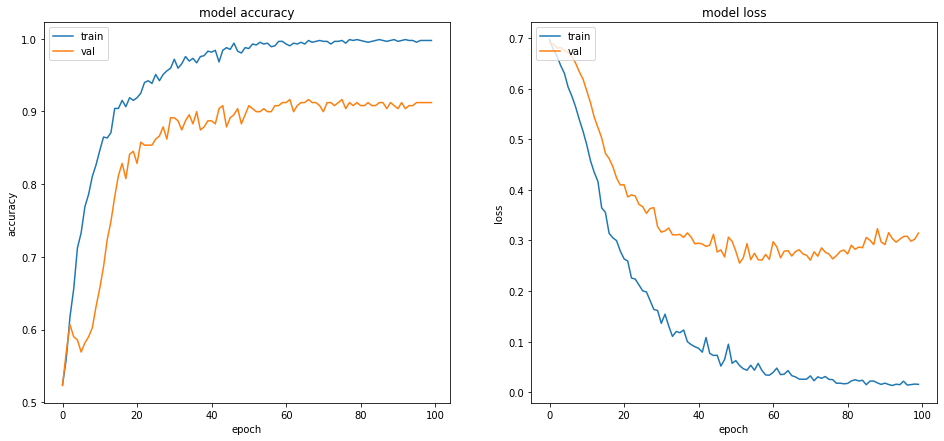

In [20]:
# summarize history for accuracy

fig,a =  plt.subplots(1, 2, figsize=(16,7))
a[0].plot(acc_train)
a[0].plot(acc_val)
a[0].set_title('model accuracy')
a[0].set_ylabel('accuracy')
a[0].set_xlabel('epoch')
a[0].legend(['train', 'val'], loc='upper left')
# summarize history for loss for epoch
# plt.figure(figsize=(10,10))
a[1].plot(loss_train)
a[1].plot(loss_val)
a[1].set_title('model loss')
a[1].set_ylabel('loss')
a[1].set_xlabel('epoch')
a[1].legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
# # Specify a path
# dir_model = '/content/drive/My Drive/DetectBrainTumor/model/pytorch/densenet201_adam.pt'
# # Save
# torch.save(trained_model, dir_model)

In [22]:
# from PIL import Image
# from pathlib import Path

# # Load
# model_densenet = torch.load(dir_model)
# model_densenet.eval()

# test_transform = transforms.Compose([
#         transforms.Resize(size=256),
#         transforms.CenterCrop(size=224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406],
#                              [0.229, 0.224, 0.225])
#     ])


# path = "/content/drive/My Drive/DetectBrainTumor/data_05052021/"
# path = "/content/drive/My Drive/DetectBrainTumor/data_24062021/"

# test_data = datasets.ImageFolder(path, transform=test_transform)  

# test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)

# # image = Image.open(Path('/content/drive/My Drive/DetectBrainTumor/data_05052021/NO/IMG-0001-00012.jpg'))
# # image = Image.open('/content/drive/My Drive/DetectBrainTumor/data_05052021/NO/IMG-0001-00012.jpg')
# # input = test_transform(image)
# # input = input.unsquueeze(0)

# with torch.no_grad():
#     correct = 0
#     total = 0
#     for images, labels in test_loader:
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model_densenet(images)
#         _, predicted = torch.max(outputs.data, 1)
#         # print(outputs)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
          
#     print('Test Accuracy of the model: {} %'.format(100 * correct / total))